In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib as mpl
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['axes.titlesize'] = 14
mpl.rcParams['legend.title_fontsize'] = 11
mpl.rcParams['legend.fontsize'] = 11
mpl.rcParams['xtick.labelsize'] = 11
mpl.rcParams['ytick.labelsize'] = 11


Read the table containg TXSSs detected in the genomes.

In [2]:
txss_info_complete = pd.read_csv('data/TXSS_info_complete.csv')

Summary the TXSSs in genomes belonging to different genera.

In [3]:
top_genus = txss_info_complete['Genus'].value_counts().reset_index()
genus_list = list(top_genus[top_genus['Genus'] >= 5]['index'])
txss_info_top_genus = txss_info_complete[txss_info_complete['Genus'].isin(
    genus_list)]
plot_txss_df = txss_info_top_genus[['TXSS/T1SS', 'TXSS/T2SS', 'TXSS/T3SS',
                                    'TXSS/T4SS', 'TXSS/T6SS', 'Genus']].groupby('Genus').mean()
plot_txss_df.columns = ['T1SS', 'T2SS', 'T3SS', 'T4SS', 'T6SS']

Heatmap for taxonomic distribution of TXSSs.

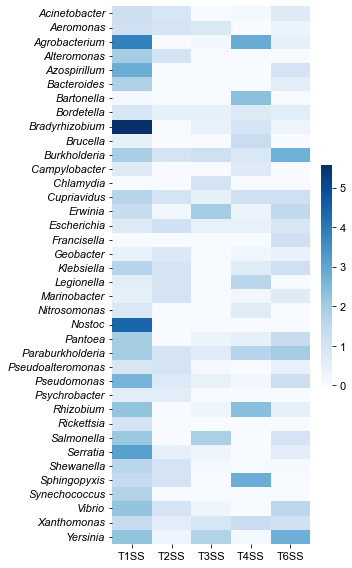

In [4]:
plt.figure(figsize=(5, 8))
ax = sns.heatmap(plot_txss_df, cmap="Blues",
                 cbar_kws=dict(location="right", fraction=0.05))
ax.set_ylabel('')
labels = ax.get_yticklabels()
[label.set_fontstyle('italic') for label in labels]
plt.tight_layout()


Plot an alternative dotplot.

In [5]:
import matplotlib.colors as mcolors

# # Define colors
# COLORS = ["#0C2C84", "#225EA8", "#1D91C0",
#           "#41B6C4", "#7FCDBB", "#C7E9B4", "#FFFFCC"]
# # Create colormap
# cmap = mcolors.LinearSegmentedColormap.from_list("colormap", COLORS[::-1], N=256)

cmap = sns.color_palette("Blues", as_cmap=True)

txss_types = ['T1SS', 'T2SS', 'T3SS', 'T4SS', 'T6SS']
plot_txss_df_new = plot_txss_df.reset_index().melt(id_vars=['Genus'], value_vars=txss_types)
geuse = list(plot_txss_df_new['Genus'].unique())
plot_txss_df_new.columns = ['Genus', 'TXSS', 'Avg. Num.']
plot_txss_df_new = plot_txss_df_new.sort_values("Genus", ascending=False)


In [6]:
def plot_heatmap(ax):
    # Iterate over types of txss
    max_num = plot_txss_df_new.max()["Avg. Num."]
    # max_num = 5
    for i, txss in enumerate(txss_types):
        # Select data for the given type of txss
        d = plot_txss_df_new[plot_txss_df_new["TXSS"] == txss]

        # Get values for the x and y axes
        y = d["Genus"]
        x = [i] * len(y)

        # Generate colors. need to normalize between 0 and 1.
        color = cmap(d["Avg. Num."]/max_num)

        # Plot the markers for the selected company
        ax.scatter(x, y, color=color, s=40*1.5**d["Avg. Num."])

    # Remove all spines
    ax.set_frame_on(False)

    # Set grid lines with some transparency
    ax.grid(alpha=0.4)

    # Make sure grid lines are behind other objects
    ax.set_axisbelow(True)

    # Set position for x ticks
    ax.set_xticks(np.arange(len(txss_types)))

    # Remove tick marks by setting their size to 0. Set text color to "0.3" (a type of grey)
    ax.tick_params(size=0, colors="0.3")
    
    # Set labels for the x ticks
    ax.set_xticklabels(txss_types, color='k')
    
    # Set label for horizontal axis.
    ax.set_xlabel("Type of Secretion Systems", loc="center")

    # Default vertical limits are shrunken by 0.75
    y_shrunk = 0.75
    y_lower, y_upper = ax.get_ylim()
    ax.set_ylim(y_lower + y_shrunk, y_upper - y_shrunk)

    return ax

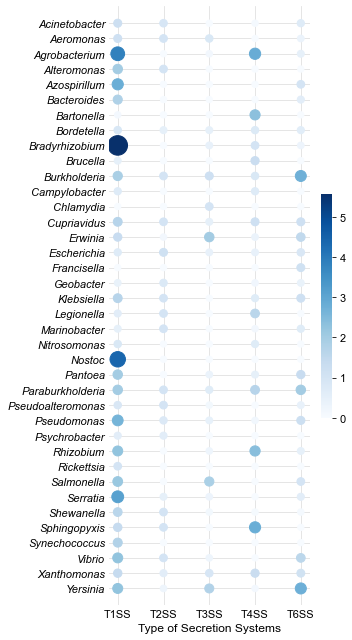

In [7]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(5, 9))

plot_heatmap(ax)

norm = mcolors.Normalize(vmin=0, vmax=plot_txss_df_new.max()["Avg. Num."])
cbar = ax.figure.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap='Blues'),
    ax=ax, extend='neither', fraction=0.05)
cbar.outline.set_visible(False)

labels = ax.get_yticklabels()
[label.set_fontstyle('italic') for label in labels]
[label.set_color('black') for label in labels]
plt.tight_layout()

plt.savefig('pdf/TXSS_heatmap.pdf')


Read the information of TXSE and compute the abundance score.

In [8]:
genome_info = pd.read_csv('data/BVBRC_genome_representative.csv')
genome_info_simple = genome_info[['Genome Name', 'Phylum', 'Class',
                                  'Order', 'Family', 'Genus', 'Species', 'Assembly Accession', 'CDS']]
genome_info_simple['assembly'] = genome_info_simple['Assembly Accession'].apply(
    lambda x: x.split('.')[0] if isinstance(x, str) else x)
genome_info_simple.drop(columns=['Assembly Accession'])


txse_list = pd.read_table('data/TXSE-list.tsv')
txse_summary = txse_list[['name', 'system', 'assembly']].groupby(
    ['system', 'assembly']).count()
txse_data = txse_summary.reset_index()
txse_info_complete = txse_data.merge(genome_info_simple, on='assembly')[
    ['Genus', 'system', 'name', 'CDS', 'Genome Name']]
txse_dict = {'I': 'T1SE', 'II': 'T2SE', 'III': 'T3SE', 'IV': 'T4SE', 'VI': 'T6SE'}
txse_info_complete['system'] = txse_info_complete['system'].apply(lambda x: txse_dict[x])
txse_info_complete['abundance'] = txse_info_complete.apply(lambda df: df['name'] / df['CDS'], axis=1)


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [9]:
table = pd.pivot_table(txse_info_complete, values='name', index=['Genome Name', 'CDS'], columns=['system'], aggfunc=np.sum, fill_value=0)
txss_info_complete = txss_info_complete.join(table, how='left', on=['Genome Name', 'CDS'])
txss_info_complete.to_csv('data/TXSS_info_complete.1.csv', index=False)

Boxplot displaying the abundance of TXSEs in several common genera.

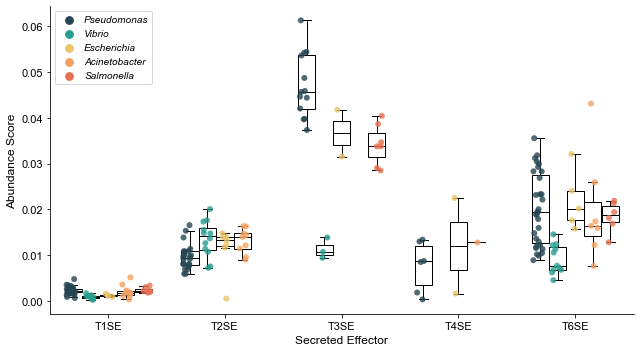

In [10]:
hue_order = ['Pseudomonas', 'Vibrio','Escherichia', 'Acinetobacter', 'Salmonella']
effector_order = ['T1SE', 'T2SE', 'T3SE', 'T4SE', 'T6SE']
plot_txse_data = txse_info_complete[txse_info_complete['Genus'].isin(hue_order)]

boxprops = {'edgecolor': 'k', 'linewidth': 1, 'facecolor': 'w'}
lineprops = {'color': 'k', 'linewidth': 1}
color_list = ['#264653', '#2a9d8f', '#e9c46a', '#f4a261', '#e76f51']
pal = sns.color_palette(color_list)
boxplot_kwargs = {'boxprops': boxprops, 'medianprops': lineprops,
                  'whiskerprops': lineprops, 'capprops': lineprops,
                  'width': 0.75, 'palette': pal,
                  'hue_order': hue_order}

stripplot_kwargs = {'linewidth': 0, 'size': 6, 'alpha': 0.8,
                    'palette': pal, 'hue_order': hue_order}

# And we can plot just like last time
fig, ax=plt.subplots(figsize=(9, 5))

sns.boxplot(x='system', y='abundance', hue='Genus',
            data=plot_txse_data, order=effector_order,
                 ax=ax, fliersize=0, **boxplot_kwargs)
sns.stripplot(x='system', y='abundance', hue='Genus',
              data=plot_txse_data,  ax=ax, order=effector_order,
                   dodge=True, jitter=0.2, **stripplot_kwargs)
# ax.legend_.remove()

sns.despine()
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles[len(hue_order):], labels[len(hue_order):],
               loc='upper left',
               prop={'size': 10, 'style': 'italic'},
               handletextpad=0.5)

ax.set_ylabel('Abundance Score')
ax.set_xlabel('Secreted Effector')
plt.tight_layout()

plt.savefig('pdf/TXSE_abundance_boxplot.pdf')


Barplot showing strains with top abudance scores for different types of effector.

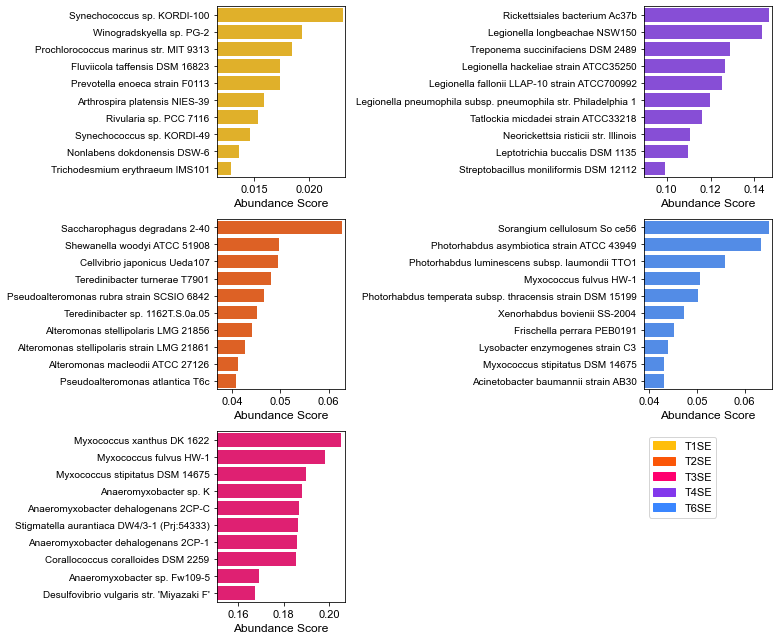

In [11]:
import matplotlib.patches as mpatches

fig, axes = plt.subplots(3, 2, figsize=(11, 9))
patches = []
effector_colors = ['#ffbe0b', '#fb5607', '#ff006e', '#8338ec', '#3a86ff']
for i, effector in enumerate(effector_order):
    x = i % 3
    y = i // 3
    top10 = txse_info_complete[txse_info_complete['system'] == effector].sort_values(by=['abundance'], ascending=False)[:10]
    sns.barplot(x="abundance", y="Genome Name", data=top10, ax=axes[x,y], color=effector_colors[i])
    axes[x, y].set_ylabel('')
    axes[x,y].set_xlim([top10['abundance'].min()*0.9, top10['abundance'].max()*1.01])
    axes[x, y].set_xlabel('Abundance Score')
    labels = axes[x, y].get_yticklabels()
    [label.set_fontsize(10) for label in labels]
    patches.append(mpatches.Patch(color=effector_colors[i], label=effector))

axes[2,1].legend(handles=patches, loc='upper left')
axes[2,1].axis("off") 

plt.tight_layout()

plt.savefig('pdf/TXSE_highest_abundance_barplot.pdf')


Heatmap/dotplot for taxonomic distribution of TXSEs

In [12]:
heatmap_txse_data = txse_info_complete[['Genus','system','abundance']].groupby(['Genus','system']).mean().reset_index()
heatmap_txse_data = heatmap_txse_data[heatmap_txse_data['Genus'].isin(genus_list)]

for genus in genus_list:
    subset = heatmap_txse_data[heatmap_txse_data['Genus'] == genus]
    effector_types = list(subset['system'])
    diff = [i for i in effector_order if i not in effector_types]
    for t in diff:
        heatmap_txse_data = heatmap_txse_data.append(
            {'Genus': genus, 'system': t, 'abundance': 0.0}, ignore_index=True)

heatmap_txse_data = heatmap_txse_data.sort_values("Genus", ascending=False)

In [13]:
effector_order = ['T1SE', 'T2SE', 'T3SE', 'T4SE', 'T6SE']

def plot_heatmap(ax):
    # Iterate over types of txss
    max_num = heatmap_txse_data.max()["abundance"]
    # max_num = 5
    for i, effector in enumerate(effector_order):
        # Select data for the given type of txss
        d = heatmap_txse_data[heatmap_txse_data["system"] == effector]

        # Get values for the x and y axes
        y = d["Genus"]
        x = [i] * len(y)

        # Generate colors. need to normalize between 0 and 1.
        color = cmap(d["abundance"]/max_num)

        # Plot the markers for the selected company
        ax.scatter(x, y, color=color, s=40*1.5**(d["abundance"]*50))

    # Remove all spines
    ax.set_frame_on(False)

    # Set grid lines with some transparency
    ax.grid(alpha=0.4)

    # Make sure grid lines are behind other objects
    ax.set_axisbelow(True)

    # Set position for x ticks
    ax.set_xticks(np.arange(len(effector_order)))

    # Remove tick marks by setting their size to 0. Set text color to "0.3" (a type of grey)
    ax.tick_params(size=0, colors="0.3")
    
     # Set labels for the x ticks
    ax.set_xticklabels(effector_order, color='k')

    # Set label for horizontal axis.
    ax.set_xlabel("Type of Secretion Secreted Effectors", loc="center")

    # Default vertical limits are shrunken by 0.75
    y_shrunk = 0.75
    y_lower, y_upper = ax.get_ylim()
    ax.set_ylim(y_lower + y_shrunk, y_upper - y_shrunk)

    return ax


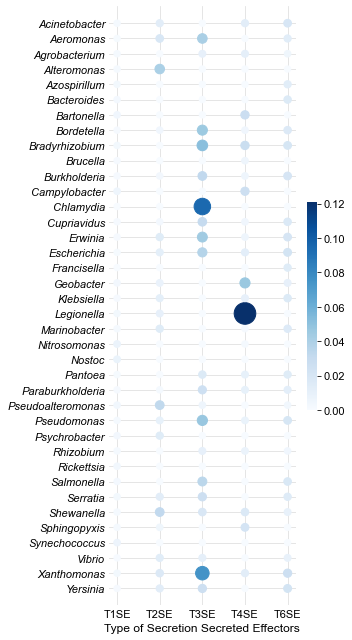

In [14]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(5, 9))

plot_heatmap(ax)

norm = mcolors.Normalize(vmin=0, vmax=heatmap_txse_data.max()["abundance"])
cbar = ax.figure.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap='Blues'),
    ax=ax, extend='neither', fraction=0.05)
cbar.outline.set_visible(False)

labels = ax.get_yticklabels()
[label.set_fontstyle('italic') for label in labels]
[label.set_color('black') for label in labels]
plt.tight_layout()

plt.savefig('pdf/TXSE_heatmap.pdf')
